In [15]:
%pip install keras
%pip install numpy
%pip install pandas
%pip install tensorflow
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np 
import pandas as pd 

import os
print(os.listdir("inputs"))

['train.tsv.zip', 'test.tsv.zip', 'Text_Similarity_Dataset.csv', '.DS_Store', 'Text_Similarity_Dataset 2.csv']


In [32]:
# lets import some stuff
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import regularizers


import re

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
df = pd.read_csv('inputs/train.tsv', delimiter='\t')
df = df[['Phrase', 'Sentiment']]

pd.set_option('display.max_colwidth', None)

df.head(3)

Phrase  \
0  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .   
1                                                                                                                 A series of escapades demonstrating the adage that what is good for the goose   
2                                                                                                                                                                                      A series   

   Sentiment  
0          1  
1          2  
2          2

In [23]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()


df['text'] = df['Phrase'].apply(clean_str)

In [24]:
df.Sentiment.value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

In [25]:
df_0 = df[df['Sentiment'] == 0].sample(frac=1)
df_1 = df[df['Sentiment'] == 1].sample(frac=1)
df_2 = df[df['Sentiment'] == 2].sample(frac=1)
df_3 = df[df['Sentiment'] == 3].sample(frac=1)
df_4 = df[df['Sentiment'] == 4].sample(frac=1)

sample_size = 7072

data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_2.head(sample_size), df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

In [26]:
data['l'] = data['Phrase'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 9.114988687782805
max length of sentence: 52
std dev length of sentence: 7.984395497010691


In [27]:
sequence_length = 52

In [28]:
max_features = 20000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(data['Phrase'].values)

X = tokenizer.texts_to_sequences(data['Phrase'].values)

X = pad_sequences(X, sequence_length)

y = pd.get_dummies(data['Sentiment']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 3536


In [33]:
embedding_dim = 200 # Kim uses 300 here
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# use a random embedding for the text
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

In [34]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 52)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 52, 200)   │  4,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 52, 200,   │          0 │ embedding_2[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 1,     │     60,100 │ reshape_1[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 49, 1,     │     80,100 │ reshape_1[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 1,     │    100,100 │ reshape_1[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 1, 100) │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 100) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 100) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 1, 100) │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 300)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │      1,505 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,241,805 (16.18 MB)

 Trainable params: 4,241,805 (16.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
batch_size = 32 
history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2021 - loss: 2.0656 - val_accuracy: 0.1982 - val_loss: 1.6294
Epoch 2/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2741 - loss: 1.6209 - val_accuracy: 0.3161 - val_loss: 1.6187
Epoch 3/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2941 - loss: 1.6013 - val_accuracy: 0.3091 - val_loss: 1.5633
Epoch 4/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3255 - loss: 1.5574 - val_accuracy: 0.3371 - val_loss: 1.5929
Epoch 5/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3561 - loss: 1.5171 - val_accuracy: 0.3534 - val_loss: 1.5392
Epoch 6/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3742 - loss: 1.4833 - val_accuracy: 0.3431 - val_loss: 1.5590
Epoch 7/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3879 - loss: 1.4540 - val_accuracy: 0.3676 - val_loss: 1.5360
Epoch 8/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3939 - loss: 1.4498 - 

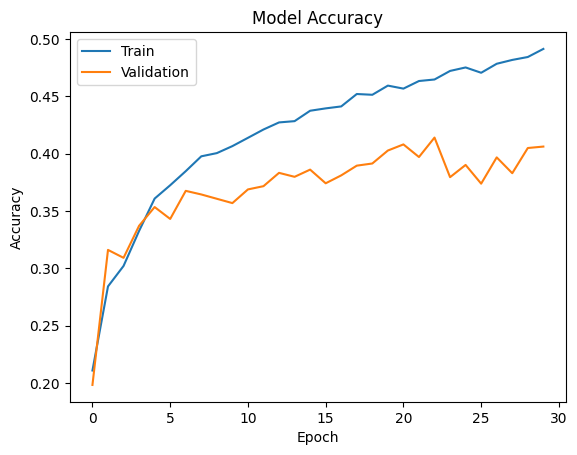

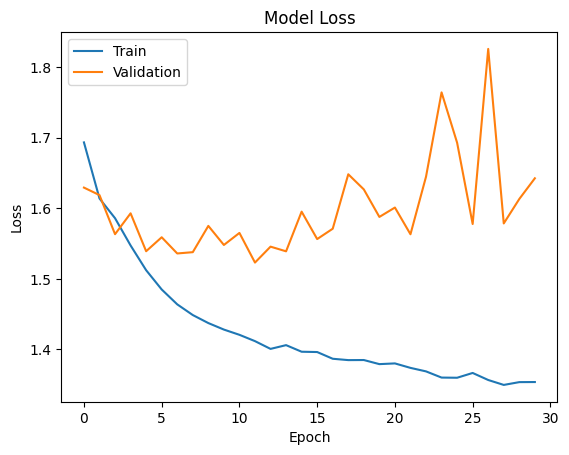

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
y_hat = model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [39]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

0.4222285067873303

In [40]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

array([[153, 268,  62, 198,  33],
       [ 86, 268, 225,  97,  24],
       [ 27, 153, 430,  87,  26],
       [ 35, 121, 148, 219, 189],
       [ 26,  51,  22, 165, 423]])

In [43]:
embeddings_index = {}
f = open(os.path.join('inputs/glove-global-vectors-for-word-representation', 'glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [44]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14097 unique tokens.


In [45]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))


for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

14098


Then our model looks almost identical to the first model, except with a different embedding layer

In [47]:
inputs_2 = Input(shape=(sequence_length,), dtype='int32')
# note the `trainable=False`, later we will make this layer trainable
embedding_layer_2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)(inputs_2)

reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_2)

conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_1_2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_2_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)

maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
maxpool_1_2 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_2)
maxpool_2_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_2)

concatenated_tensor_2 = Concatenate(axis=1)([maxpool_0_2, maxpool_1_2, maxpool_2_2])
flatten_2 = Flatten()(concatenated_tensor_2)

dropout_2 = Dropout(0.5)(flatten_2)
output_2 = Dense(units=5, activation='softmax')(dropout_2)

In [48]:
model_2 = Model(inputs=inputs_2, outputs=output_2)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 52)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 52, 200)   │  2,819,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 52, 200,   │          0 │ embedding_4[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 1,     │     60,100 │ reshape_2[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 49, 1,     │     80,100 │ reshape_2[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 48, 1,     │    100,100 │ reshape_2[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 100) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 1, 1, 100) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 1, 1, 100) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3, 1, 100) │          0 │ max_pooling2d_3[… │
│ (Concatenate)       │                   │            │ max_pooling2d_4[… │
│                     │                   │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 300)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 300)       │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      1,505 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,061,405 (11.68 MB)

 Trainable params: 3,061,405 (11.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [49]:
batch_size = 32
history_2 = model_2.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.2791 - loss: 2.2505 - val_accuracy: 0.4341 - val_loss: 1.8087
Epoch 2/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4449 - loss: 1.8102 - val_accuracy: 0.5112 - val_loss: 1.6928
Epoch 3/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5119 - loss: 1.7079 - val_accuracy: 0.5367 - val_loss: 1.7145
Epoch 4/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5324 - loss: 1.6500 - val_accuracy: 0.5342 - val_loss: 1.6941
Epoch 5/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5485 - loss: 1.6043 - val_accuracy: 0.4905 - val_loss: 1.7174
Epoch 6/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5627 - loss: 1.5858 - val_accuracy: 0.5082 - val_loss: 1.6335
Epoch 7/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5702 - loss: 1.5506 - val_accuracy: 0.5453 - val_loss: 1.6301
Epoch 8/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5863 - loss: 1.5193 - 

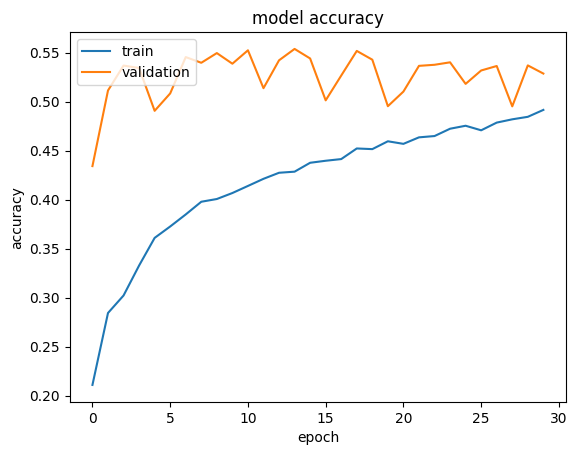

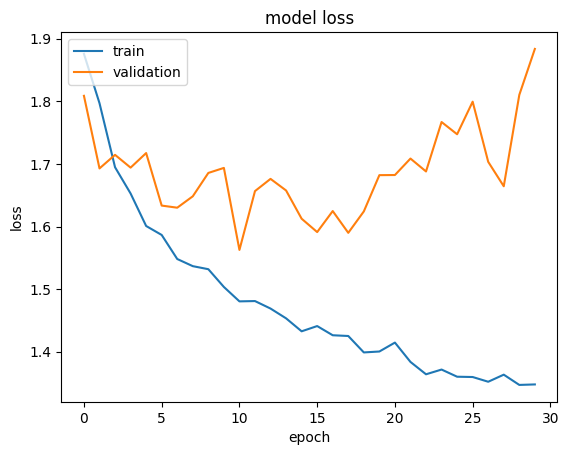

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [54]:
y_hat_2 = model_2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [55]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

0.5226244343891403

In [56]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

array([[467, 173,  23,  32,  19],
       [211, 233, 140,  91,  25],
       [ 41, 106, 383, 158,  35],
       [ 26,  34, 116, 293, 243],
       [ 11,   4,  15, 185, 472]])

In [58]:
inputs_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=True)(inputs_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

# note the relu activation
conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = Flatten()(concatenated_tensor_3)

dropout_3 = Dropout(0.5)(flatten_3)
output_3 = Dense(units=5, activation='softmax')(dropout_3)

In [59]:
model_3 = Model(inputs=inputs_3, outputs=output_3)
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 52)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 52, 200)   │  2,819,600 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 52, 200,   │          0 │ embedding_6[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 50, 1,     │     60,100 │ reshape_3[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 49, 1,     │     80,100 │ reshape_3[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 1,     │    100,100 │ reshape_3[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 1, 1, 100) │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 1, 1, 100) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 1, 1, 100) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3, 1, 100) │          0 │ max_pooling2d_6[… │
│ (Concatenate)       │                   │            │ max_pooling2d_7[… │
│                     │                   │            │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 300)       │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 300)       │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      1,505 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,061,405 (11.68 MB)

 Trainable params: 3,061,405 (11.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [60]:
batch_size = 32
history_3 = model_3.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.2878 - loss: 2.2601 - val_accuracy: 0.4236 - val_loss: 1.8221
Epoch 2/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4397 - loss: 1.8032 - val_accuracy: 0.4910 - val_loss: 1.7037
Epoch 3/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5074 - loss: 1.7072 - val_accuracy: 0.5346 - val_loss: 1.6395
Epoch 4/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5323 - loss: 1.6564 - val_accuracy: 0.5257 - val_loss: 1.6511
Epoch 5/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5583 - loss: 1.6108 - val_accuracy: 0.5276 - val_loss: 1.8408
Epoch 6/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5656 - loss: 1.5892 - val_accuracy: 0.5455 - val_loss: 1.6101
Epoch 7/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5769 - loss: 1.5397 - val_accuracy: 0.5570 - val_loss: 1.6103
Epoch 8/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5887 - loss: 1.5199 - 

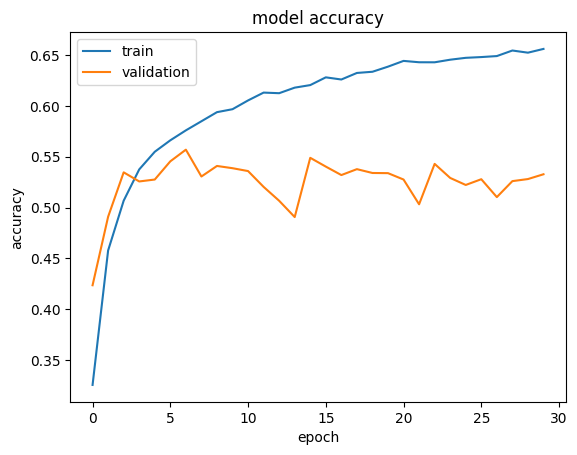

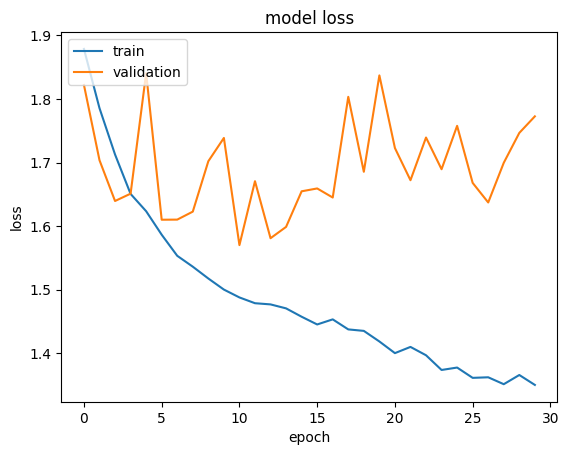

In [61]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [62]:
y_hat_3 = model_3.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [63]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))

0.5265837104072398

In [64]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))

array([[433, 216,  28,  21,  16],
       [166, 289, 161,  58,  26],
       [ 35, 113, 381, 149,  45],
       [ 20,  39, 123, 236, 294],
       [ 12,   7,  16, 129, 523]])

In [65]:
sst2_data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

def merge_sentiments(x):
    if x == 0 or x == 1:
        return 0
    else:
        return 1

sst2_data['Sentiment'] = sst2_data['Sentiment'].apply(merge_sentiments)

sst2_tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
sst2_tokenizer.fit_on_texts(sst2_data['Phrase'].values)

sst2_X = sst2_tokenizer.texts_to_sequences(sst2_data['Phrase'].values)
sst2_X = pad_sequences(sst2_X, sequence_length)

sst2_y = sst2_data['Sentiment'].values

sst2_X_train, sst2_X_test, sst2_y_train, sst2_y_test = train_test_split(sst2_X, sst2_y, test_size=0.1)

In [67]:
inputs_4 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_4 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=True)(inputs_4)

reshape_4 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_4)

conv_0_4 = Conv2D(num_filters, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
conv_1_4 = Conv2D(num_filters, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
conv_2_4 = Conv2D(num_filters, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)

maxpool_0_4 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_4)
maxpool_1_4 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_4)
maxpool_2_4 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_4)

concatenated_tensor_4 = Concatenate(axis=1)([maxpool_0_4, maxpool_1_4, maxpool_2_4])
flatten_4 = Flatten()(concatenated_tensor_4)

dropout_4 = Dropout(0.5)(flatten_4)

output_4 = Dense(units=1, activation='sigmoid')(dropout_4)

In [68]:
model_4 = Model(inputs=inputs_4, outputs=output_4)

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_4.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 52)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 52, 200)   │  2,819,600 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 52, 200,   │          0 │ embedding_8[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 50, 1,     │     60,100 │ reshape_4[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 49, 1,     │     80,100 │ reshape_4[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 48, 1,     │    100,100 │ reshape_4[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 1, 1, 100) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 1, 1, 100) │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 1, 1, 100) │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3, 1, 100) │          0 │ max_pooling2d_9[… │
│ (Concatenate)       │                   │            │ max_pooling2d_10… │
│                     │                   │            │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 300)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 300)       │          0 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        301 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,060,201 (11.67 MB)

 Trainable params: 3,060,201 (11.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
batch_size = 32
history_4 = model_4.fit(sst2_X_train, sst2_y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5058 - loss: 314.2126 - val_accuracy: 0.4959 - val_loss: 0.6989
Epoch 2/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5050 - loss: 0.6975 - val_accuracy: 0.5041 - val_loss: 0.6974
Epoch 3/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5040 - loss: 0.6970 - val_accuracy: 0.5041 - val_loss: 0.6957
Epoch 4/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5012 - loss: 0.6964 - val_accuracy: 0.5041 - val_loss: 0.6962
Epoch 5/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4993 - loss: 0.6957 - val_accuracy: 0.5041 - val_loss: 0.6957
Epoch 6/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5087 - loss: 0.6955 - val_accuracy: 0.4959 - val_loss: 0.6952
Epoch 7/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4995 - loss: 0.6955 - val_accuracy: 0.5554 - val_loss: 0.6961
Epoch 8/30
637/637 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5082 - loss: 0.6957 - va

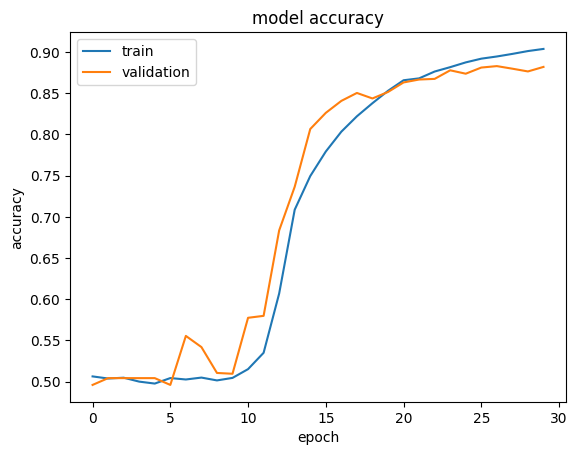

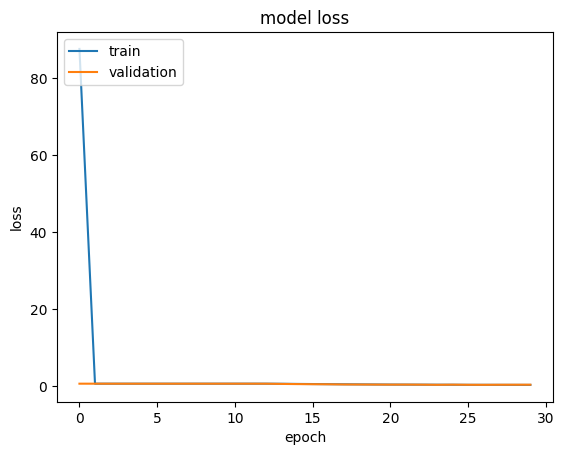

In [71]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [72]:
y_hat_4 = model_4.predict(sst2_X_test)

accuracy_score(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


0.8766348533050548

In [73]:
confusion_matrix(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))

array([[1221,  182],
       [ 167, 1259]])

In [74]:
print("CNN random       : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))))
print("CNN static       : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))))
print("CNN trainable    : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))))
print("Binary trainable : " + str(accuracy_score(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))))

CNN random       : 0.4222285067873303
CNN static       : 0.5226244343891403
CNN trainable    : 0.5265837104072398
Binary trainable : 0.8766348533050548
